<a href="https://colab.research.google.com/github/nimaafshari/TF_Training_Sessions/blob/main/TF_Training_Session_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Session 3: Basic regression: Predict fuel efficiency

In a *regression* problem, the aim is to predict the output of a continuous value, like a price or a probability. Contrast this with a *classification* problem, where the aim is to select a class from a list of classes (for example, where a picture contains an apple or an orange, recognizing which fruit is in the picture).

This notebook uses the classic [Auto MPG] (Mileage per gallon) (https://archive.ics.uci.edu/ml/datasets/auto+mpg) Dataset and builds a model to predict the fuel efficiency of late-1970s and early 1980s automobiles. To do this, provide the model with a description of many automobiles from that time period. This description includes attributes like: cylinders, displacement, horsepower, and weight.


In [20]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.utils import plot_model


print(tf.__version__)
# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

2.4.1


Download the dataset and look into that

In [21]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


The Origin column is the country of origin which is a nominal categorical varible must not converted into consecutive numerical numbers. We convert them into On-hot encoding.

In [22]:
dataset = dataset.dropna()
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


The dataset is ready to go to the ANN model creation process. we should first split that into train/test sets to avoid any leaking

In [23]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

### Split features from labels

Separate the target value, the "label", from the features. This label is the value that you will train the model to predict.

In [24]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

### Inspect the data

Have a quick look at the joint distribution of a few pairs of columns from the training set.

Looking at the top row it should be clear that the fuel efficiency (MPG) is a function of all the other parameters. Looking at the other rows it should be clear that they are each functions of eachother.

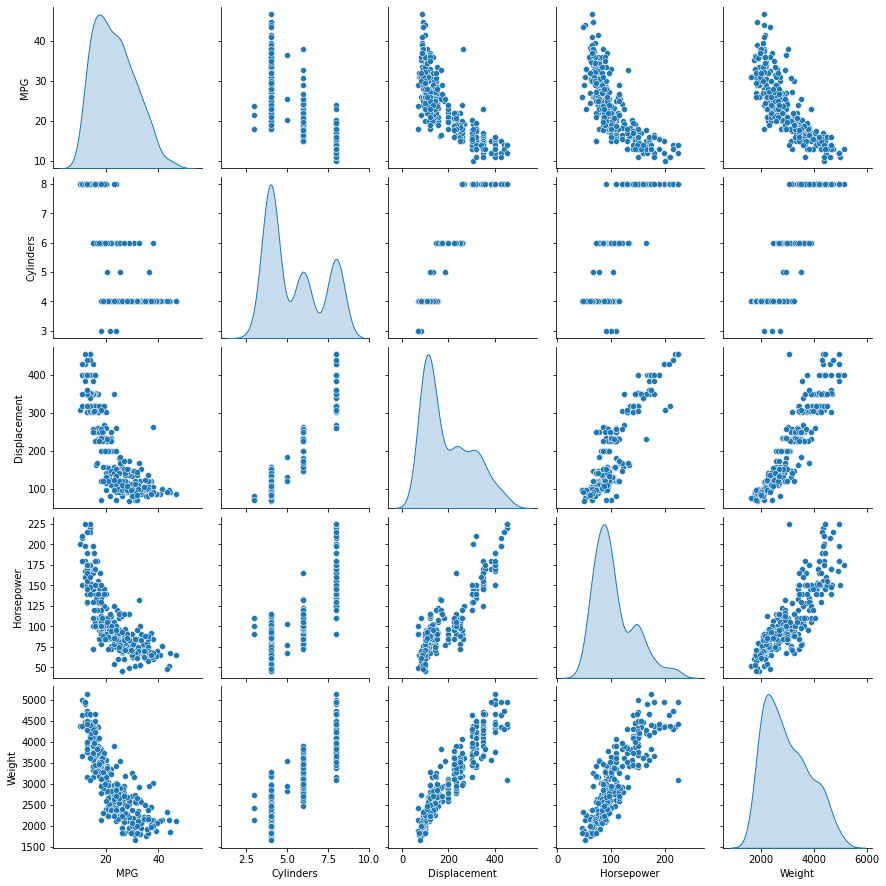

In [25]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Horsepower','Weight']], diag_kind='kde')#, kind = 'reg')

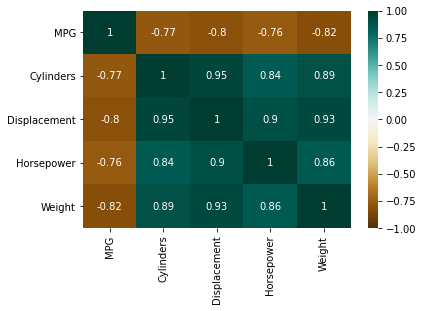

In [26]:
sns.heatmap(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Horsepower','Weight']].corr(), vmin=-1, vmax=1, annot=True, cmap = 'BrBG');

Linear Regression with one input (Horsepower)

Here we will incorporate the normalization layer into the neural network to make it able to tune its parameters.

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_4 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


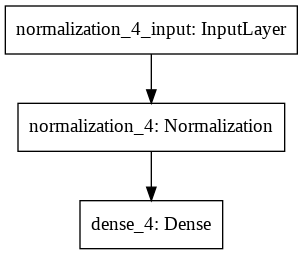

In [41]:
horsepower = np.array(train_features['Horsepower'])

horsepower_normalizer = preprocessing.Normalization(input_shape=[1,])
horsepower_normalizer.adapt(horsepower)

horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units=1)
])

horsepower_model.summary()
plot_model(horsepower_model)

In [42]:
horsepower_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error',
    metrics = ['mae'])

history = horsepower_model.fit(
    train_features['Horsepower'], train_labels,
    epochs=100,
    verbose=1,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

Epoch 1/100
8/8 [==============================] - 1s 29ms/step - loss: 22.7505 - mae: 22.7505 - val_loss: 22.9313 - val_mae: 22.9313
Epoch 2/100
8/8 [==============================] - 0s 7ms/step - loss: 21.7113 - mae: 21.7113 - val_loss: 22.1316 - val_mae: 22.1316
Epoch 3/100
8/8 [==============================] - 0s 7ms/step - loss: 21.6262 - mae: 21.6262 - val_loss: 21.3314 - val_mae: 21.3314
Epoch 4/100
8/8 [==============================] - 0s 7ms/step - loss: 20.1603 - mae: 20.1603 - val_loss: 20.5316 - val_mae: 20.5316
Epoch 5/100
8/8 [==============================] - 0s 8ms/step - loss: 19.8813 - mae: 19.8813 - val_loss: 19.7314 - val_mae: 19.7314
Epoch 6/100
8/8 [==============================] - 0s 7ms/step - loss: 18.8017 - mae: 18.8017 - val_loss: 18.9314 - val_mae: 18.9314
Epoch 7/100
8/8 [==============================] - 0s 8ms/step - loss: 18.0920 - mae: 18.0920 - val_loss: 18.1313 - val_mae: 18.1313
Epoch 8/100
8/8 [==============================] - 0s 8ms/step - los

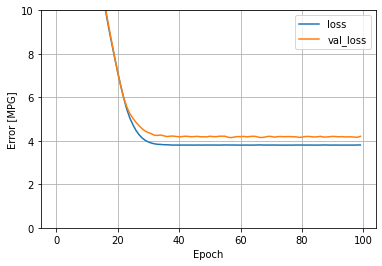

In [43]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

plot_loss(history)